In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Prep the Data

In [2]:
!kaggle datasets download -d pybear/cats-vs-dogs

100% 787M/788M [00:08<00:00, 160MB/s]
100% 788M/788M [00:08<00:00, 97.5MB/s]


In [3]:
!unzip cats-vs-dogs.zip

Streaming output truncated to the last 5000 lines.
  inflating: PetImages/Dog/550.jpg   
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  

In [5]:
!ls PetImages/

Cat  Dog


In [6]:
!ls PetImages/Cat | wc -l

12501


In [7]:
!ls PetImages/Dog | wc -l

12501


In [8]:
import os
import random
import pathlib
import shutil
import matplotlib.pyplot as plt

In [9]:
# Distinct image classes
img_classes = ['cat', 'dog']

# Folders for training, testing, and validation subsets
dir_data  = pathlib.Path.cwd().joinpath('data')
dir_train = dir_data.joinpath('train')
dir_valid = dir_data.joinpath('validation')
dir_test  = dir_data.joinpath('test')

# Train/Test/Validation split config
pct_train = 0.8
pct_valid = 0.1
pct_test = 0.1

In [10]:
def setup_folder_structure() -> None:
    # Create base folders if they don't exist
    if not dir_data.exists():  dir_data.mkdir()
    if not dir_train.exists(): dir_train.mkdir()
    if not dir_valid.exists(): dir_valid.mkdir()
    if not dir_test.exists():  dir_test.mkdir()

    # Create subfolders for each class
    for cls in img_classes:
        if not dir_train.joinpath(cls).exists(): dir_train.joinpath(cls).mkdir()
        if not dir_valid.joinpath(cls).exists(): dir_valid.joinpath(cls).mkdir()
        if not dir_test.joinpath(cls).exists():  dir_test.joinpath(cls).mkdir()

    # Print the directory structure
    # Credits - https://stackoverflow.com/questions/3455625/linux-command-to-print-directory-structure-in-the-form-of-a-tree
    dir_str = os.system('''ls -R data | grep ":$" | sed -e 's/:$//' -e 's/[^-][^\/]*\//--/g' -e 's/^/   /' -e 's/-/|/' ''')
    print(dir_str)
    return


setup_folder_structure()

0


In [11]:
def train_test_validation_split(src_folder: pathlib.PosixPath, class_name: str) -> dict:
    # For tracking
    n_train, n_valid, n_test = 0, 0, 0

    # Random seed for reproducibility
    random.seed(42)

    # Iterate over every image
    for file in src_folder.iterdir():
        img_name = str(file).split('/')[-1]

        # Make sure it's JPG
        if file.suffix == '.jpg':
            # Generate a random number
            x = random.random()

            # Where should the image go?
            tgt_dir = ''

            # .80 or below
            if x <= pct_train:
                tgt_dir = 'train'
                n_train += 1

            # Between .80 and .90
            elif pct_train < x <= (pct_train + pct_valid):
                tgt_dir = 'validation'
                n_valid += 1

            # Above .90
            else:
                tgt_dir = 'test'
                n_test += 1

            # Copy the image
            shutil.copy(
                src=file,
                # data/<train|valid|test>/<cat\dog>/<something>.jpg
                dst=f'{str(dir_data)}/{tgt_dir}/{class_name}/{img_name}'
            )

    return {
        'source': str(src_folder),
        'target': str(dir_data),
        'n_train': n_train,
        'n_validaiton': n_valid,
        'n_test': n_test
    }

In [12]:
%%time

train_test_validation_split(
    src_folder=pathlib.Path.cwd().joinpath('PetImages/Cat'),
    class_name='cat'
)

CPU times: user 771 ms, sys: 2.41 s, total: 3.18 s
Wall time: 3.41 s


{'source': '/content/PetImages/Cat',
 'target': '/content/data',
 'n_train': 10016,
 'n_validaiton': 1239,
 'n_test': 1245}

In [13]:
%%time

train_test_validation_split(
    src_folder=pathlib.Path.cwd().joinpath('PetImages/Dog'),
    class_name='dog'
)

CPU times: user 712 ms, sys: 1.89 s, total: 2.6 s
Wall time: 2.71 s


{'source': '/content/PetImages/Dog',
 'target': '/content/data',
 'n_train': 10016,
 'n_validaiton': 1239,
 'n_test': 1245}

In [14]:
def plot_random_sample(img_dir: pathlib.PosixPath):
    # How many images we're showing
    n = 10
    # Get absolute paths to these N images
    imgs = random.sample(list(img_dir.iterdir()), n)

    # Make sure num_row * num_col = n
    num_row = 2
    num_col = 5

    # Create a figure
    fig, axes = plt.subplots(num_row, num_col, figsize=(3.5 * num_col, 3 * num_row))
    # For every image
    for i in range(num_row * num_col):
        # Read the image
        img = plt.imread(str(imgs[i]))
        # Display the image
        ax = axes[i // num_col, i % num_col]
        ax.imshow(img)
        # Set title as <train|test|validation>/<cat\dog>/<img_name>.jpg
        ax.set_title('/'.join(str(imgs[i]).split('/')[-3:]))

    plt.tight_layout()
    plt.show()

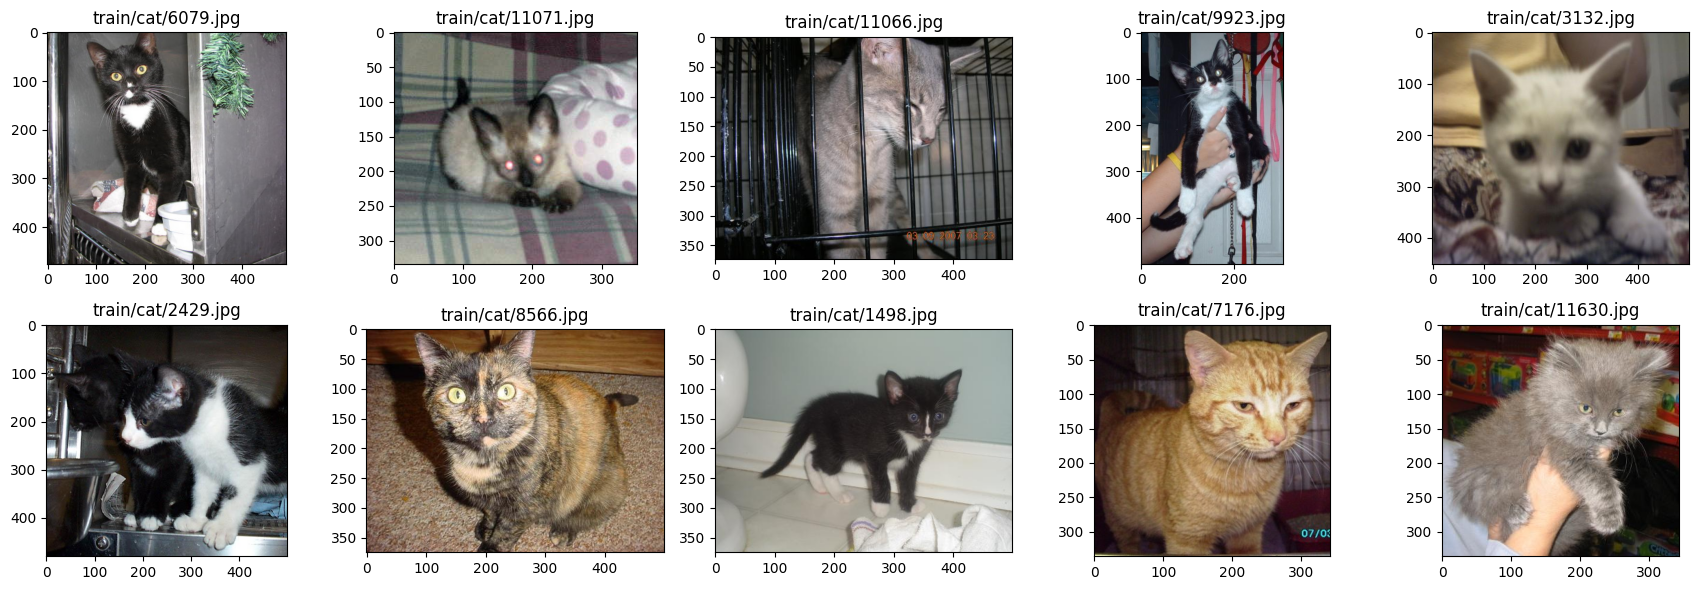

In [15]:
plot_random_sample(img_dir=pathlib.Path().cwd().joinpath('data/train/cat'))

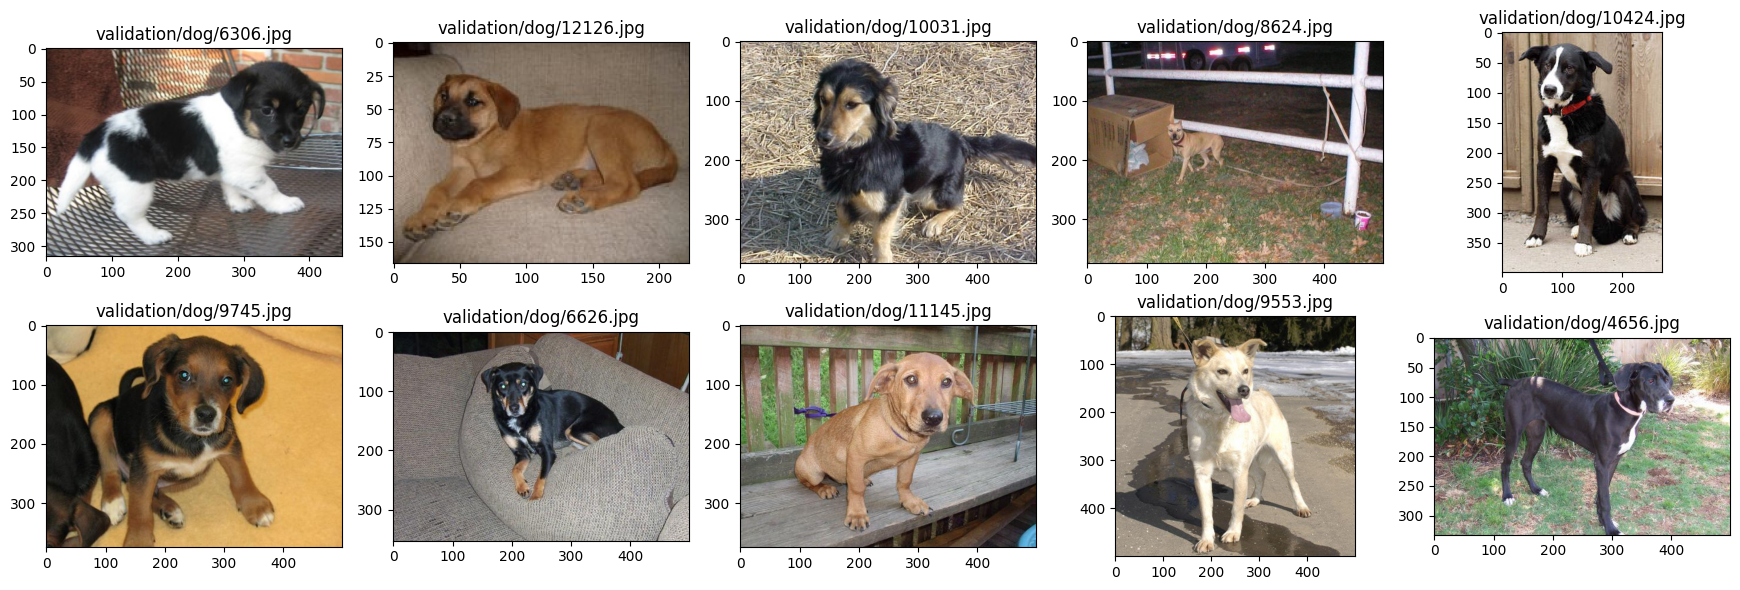

In [16]:
plot_random_sample(img_dir=pathlib.Path().cwd().joinpath('data/validation/dog'))

# Convolutional Neural Network... NO theory YET

In [17]:
import os
import pathlib
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(42)

from PIL import Image, ImageOps
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

(281, 300, 3)


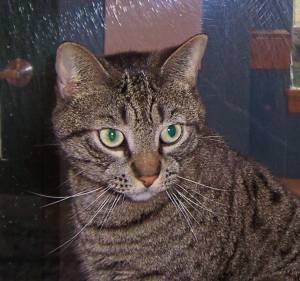

In [18]:
img1 = Image.open('data/train/cat/1.jpg')
print(np.array(img1).shape)
display(img1)

(375, 500, 3)


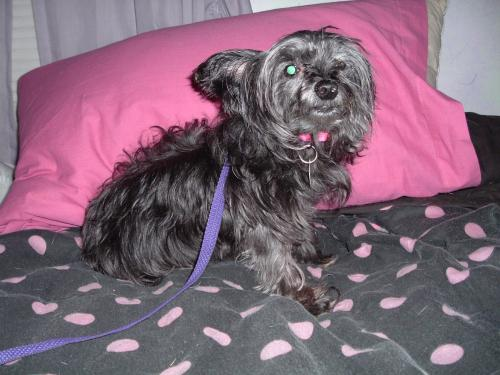

In [19]:
img2 = Image.open('data/train/dog/0.jpg')
print(np.array(img2).shape)
display(img2)

In [20]:
np.array(img2) / 255.0

array([[[0.45882353, 0.45098039, 0.49411765],
        [0.45882353, 0.45098039, 0.49411765],
        [0.46666667, 0.45882353, 0.50980392],
        ...,
        [0.51764706, 0.51764706, 0.55686275],
        [0.51372549, 0.51372549, 0.55294118],
        [0.51372549, 0.51372549, 0.55294118]],

       [[0.4627451 , 0.45490196, 0.49803922],
        [0.45882353, 0.45098039, 0.49411765],
        [0.46666667, 0.45882353, 0.50980392],
        ...,
        [0.5254902 , 0.5254902 , 0.56470588],
        [0.52156863, 0.52156863, 0.56078431],
        [0.52156863, 0.52156863, 0.56078431]],

       [[0.46666667, 0.45882353, 0.50196078],
        [0.4627451 , 0.45490196, 0.49803922],
        [0.47058824, 0.4627451 , 0.51372549],
        ...,
        [0.53333333, 0.53333333, 0.57254902],
        [0.52941176, 0.52941176, 0.56862745],
        [0.52941176, 0.52941176, 0.56862745]],

       ...,

       [[0.29411765, 0.31372549, 0.32941176],
        [0.2745098 , 0.29411765, 0.30980392],
        [0.27058824, 0

In [21]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)

In [22]:
train_data = train_datagen.flow_from_directory(
    directory='data/train/',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=64,
    seed=42
)

Found 20032 images belonging to 2 classes.


In [23]:
first_batch = train_data.next()

In [24]:
first_batch[0].shape, first_batch[1].shape

((64, 224, 224, 3), (64, 2))

In [25]:
def visualize_batch(batch: tf.keras.preprocessing.image.DirectoryIterator):
    n = 64
    num_row, num_col = 8, 8
    fig, axes = plt.subplots(num_row, num_col, figsize=(3 * num_col, 3 * num_row))

    for i in range(n):
        img = np.array(batch[0][i] * 255, dtype='uint8')
        ax = axes[i // num_col, i % num_col]
        ax.imshow(img)

    plt.tight_layout()
    plt.show()


visualize_batch(batch=first_batch)

Output hidden; open in https://colab.research.google.com to view.